In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.cm as cm
import pickle as pkl
import matplotlib.pyplot as plt
# Single methods
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH
import folium
from folium.plugins import HeatMap

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

In [4]:
root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"
model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


In [5]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)

In [6]:
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

In [7]:
mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X)
X_UMAP = mapper.transform(X)

In [8]:
X_UMAP_df = pd.DataFrame(X_UMAP, columns=['UMAP1', 'UMAP2'])

df_UMAP = df_ae.copy()

X_UMAP_df.index = df_UMAP.index

cols_to_replace = [str(i) for i in range(25920)]  # Nombres de columnas como strings

existing_cols = [col for col in cols_to_replace if col in df_UMAP.columns]

df_UMAP = df_UMAP.drop(columns=existing_cols)

df_UMAP = pd.concat([df_UMAP, X_UMAP_df], axis=1)

print(df_UMAP.head())



                            y location  day  hour hour_stage    cover habitat  \
0  RZUA01_20220903_180000.WAV   RZUA01    3    18      night  pasture  bosque   
1  RZUA01_20220903_181500.WAV   RZUA01    3    18      night  pasture  bosque   
2  RZUA01_20220903_183000.WAV   RZUA01    3    18      night  pasture  bosque   
3  RZUA01_20220903_184500.WAV   RZUA01    3    18      night  pasture  bosque   
4  RZUA01_20220903_190000.WAV   RZUA01    3    19      night  pasture  bosque   

  rain_FI     UMAP1     UMAP2  
0      NO  0.417370  9.998250  
1      NO  1.615335  6.925817  
2      NO  0.631278  9.015840  
3      NO  0.697975  6.213332  
4      NO  0.715682  6.252186  


In [8]:
Clustering = KMeans(n_clusters=10, random_state=0).fit(X_UMAP)
Results = ClusteringResults(Clustering, df_UMAP, y_label="hour")
df_new = Results.tagger()
df_new.set_index("y", inplace=True, drop=False)
df_new.rename_axis('Filename_', inplace=True)

audios_filtered = audios[audios.index.isin(df_new.index)]
audios_final = audios_filtered.join(df_new['cluster'], how='left')


conteo_clusters = audios_final.groupby(['location', 'cluster']).size().unstack(fill_value=0)
conteo_clusters.columns = [f'cluster_{col}' for col in conteo_clusters.columns]
recorders_clusters = recorders.join(conteo_clusters, on='field_number_PR')

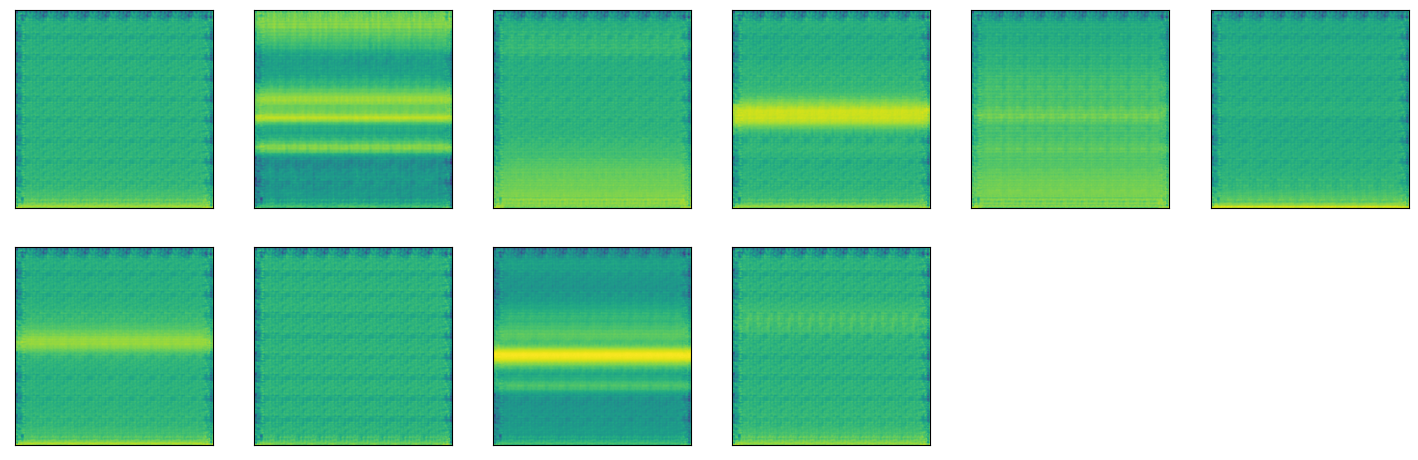

Ploted!


In [9]:
%matplotlib inline
cluster_centers = Clustering.cluster_centers_ #Normalizer_.inverse_transform(Kmeans.cluster_centers_)
cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
plot_centroids(cluster_centers_inverse, testing,) # save=True, #cluster_centers_inverse for UMAP, root=f"temporal_zamuro/zamuro_clustering_results/Kmeans_Normal/")

In [9]:
# Supongamos que quieres verificar los datos para una grabadora específica, por ejemplo, "grabadora_1"
grabadora = "RZUH12"  # Cambia esto al nombre de la grabadora que quieres verificar

# Filtrar los datos de audios_final para esta grabadora específica
audios_grabadora = audios_final[audios_final['location'] == grabadora]

# Contar la cantidad de audios en cada cluster para esta grabadora
conteo_por_cluster = audios_grabadora['cluster'].value_counts()

# Mostrar el resultado
print(conteo_por_cluster)

NameError: name 'audios_final' is not defined

In [11]:
conteo_clusters = audios_final['cluster'].value_counts()

# Mostrar el resultado
print(conteo_clusters)

cluster
1    10711
0     7505
8     7213
6     7194
3     6971
9     5176
5     3648
4     2694
2     1749
7      414
Name: count, dtype: int64


In [12]:
%matplotlib qt
mapa = folium.Map(location=[3.515, -73.411489], zoom_start=13.2)

puntos = recorders_clusters[['latitude_IG', 'longitud_IG', 'cluster_1']].values.tolist()
valores = recorders_clusters["cluster_1"].tolist()
HeatMap(puntos, radius=18, ).add_to(mapa)
mapa

In [14]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from scipy.interpolate import griddata

In [17]:
# Filtrar el DataFrame eliminando las filas donde field_number_PR sea igual a 'RZUD06'
recorders_clusters = recorders_clusters[recorders_clusters['field_number_PR'] != 'RZUD06']

# Opcional: resetear el índice si es necesario
recorders_clusters.reset_index(drop=True, inplace=True)

In [18]:
geometry = [Point(xy) for xy in zip(recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG'])]
gdf = gpd.GeoDataFrame(recorders_clusters, geometry=geometry)

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = 'Complementary_Files/AD.tif'

with rasterio.open(tif_path) as tif:
    bounds = tif.bounds

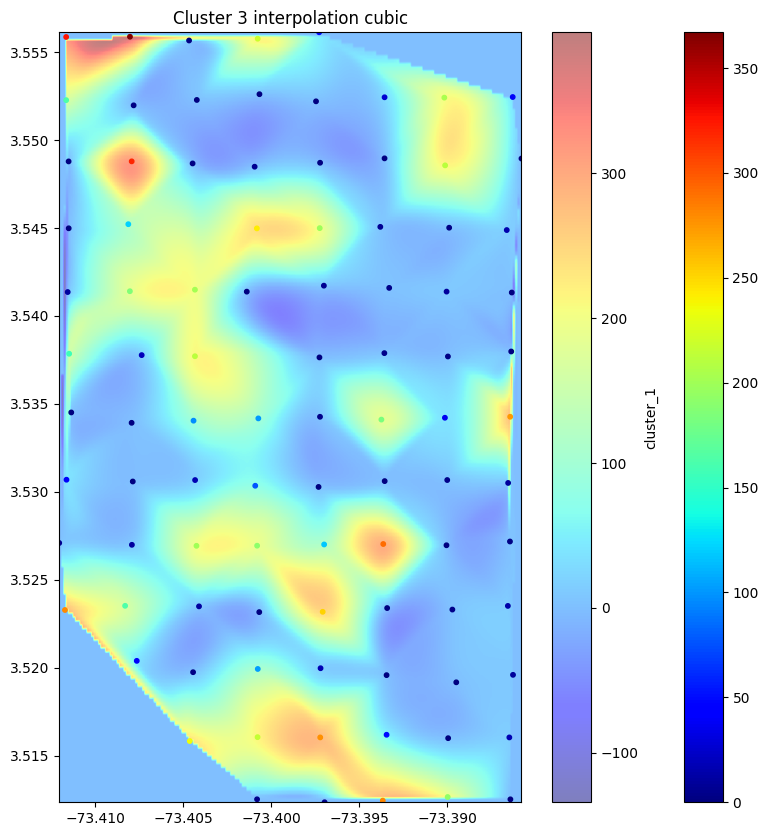

In [27]:
%matplotlib inline
resolution = 200

# Crea una cuadrícula regular para la interpolación
x_min, x_max = recorders_clusters['longitud_IG'].min(), recorders_clusters['longitud_IG'].max()
y_min, y_max = recorders_clusters['latitude_IG'].min(), recorders_clusters['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Realiza la interpolación utilizando griddata
Z3 = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']), recorders_clusters['cluster_8'], (X, Y), method='cubic',fill_value=0)

fig, ax = plt.subplots(figsize=(10, 10))

# Visualiza los puntos originales
gdf.plot(ax=ax, column='cluster_8', cmap='jet', markersize=10, legend=True)

# Visualiza la interpolación como un mapa de calor
im = ax.imshow(Z3, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
plt.colorbar(im, ax=ax, label='cluster_1')
limited_dataimg = im.get_array()

ax.set_title('Cluster 3 interpolation cubic')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

X= GLM[[f"Cluster {i}" for i in range(len(GLM.columns)-6)]]
X = X.to_numpy()
y = GLM["Mean"]